## Imports


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from PIL import Image
from skimage import io, transform
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from google.colab import drive

## Set up GPU capabilities 

The cell below sets up a CUDA device to use with torch.

**Remeber to turn on the GPU for runtime in Colab**
*   Go to Runtime -> Change runtime type --> GPU


In [3]:

torch.manual_seed(42) # For consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.0.0+cu118
cuda:0


In [4]:
device

device(type='cuda', index=0)

# **Part 1:** Data Preprocessing and Preparation for Modeling in `PyTorch`

In this project we will tackle the problem of classifying images.

Specifically, we would be looking at the Modified National Institute of Standards and Technology database ([MNIST](https://en.wikipedia.org/wiki/MNIST_database)) dataset.

<div>
<img src="https://s2.loli.net/2023/03/26/GwFJhNeskzE5Ptx.webp", width="800"/>
</div>

Diagram Reference: [Link](https://en.wikipedia.org/wiki/MNIST_database)

[MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html) dataset consists of 60,000 28x28 grayscale images in 10 classes. 

There are 60,000 training images and 10,000 test images.

While it is good to have as much training data as possible, in order to avoid having long training time and potentially running out of GPU, we will downsample and train the model with 30,000 training images and 5,000 testing images.


We would be using this dataset to train 3 different models:

1.   Logistic Regression
2.   Feedforward (Fully-Connected) Neural Network
3.   Convolutional Neural Network

And analyze the difference between these models by looking at the test accuracy and loss.



## 1.1 Pytorch Dataset and DataLoader

To keep data loading consistent across different models, PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data.

`Dataset` stores the samples and their corresponding labels. And `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples. More information and examples of the objects in action can be found **[here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)**

While Pytorch provides `Dataset` and `Dataloader` for some popular datasets (i.e., one can instantiate the objects and the data is ready to be analyzed in PyTorch Machine Learning pipeline), sometimes we need to define our own custom `Dataset` to process our dataset. The list of available built-in datasets PyTorch gave us can be found **[here](https://pytorch.org/vision/stable/datasets.html)**

<div>
<img src="https://s2.loli.net/2023/03/30/yxbP8gXCroO1Y7c.png", width="800"/>
</div>

Diagram Reference: [Link](https://www.kaggle.com/code/uvxy1234/cifar-10-implementation-with-pytorch)

Dataset class is defined with 3 components:

1.   __init__ : setting up the parameters being used in the class (e.g., `transforms` which corresponds to the transformation being applied)
2.   __len__ : so that len(dataset) returns the size of the dataset.
3.   __getitem__ to support the indexing such that `dataset[i]` can be used to get `i`ith sample (in our case Image, label pair).

To create a custom Dataset object, you would need overide above functions.

Documentation for creating custom dataset can be found [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

Luckily, as MNIST is a classic image dataset, we do not need to worry about creating custom `Dataset` and `DataLoader` objects since they are all built into the PyTorch when you import that above.

Complete the missing code in the two sections below.

*   **1.1.1 Instantiate Train and Test Dataset.** $\to$ Load and transform data such that it is ready to be passed into the model
*   **1.1.2 Instantiate Train and Test Dataloader.** $\to$ Put the data into the iterable such that the model is able to process data in batch from using `DataLoader`


### 1.1.1 Instantiate Dataset (for train/test dataset)
One optional function in Dataset class is `transform`, where we can apply a transformation to the dataset before we load them as a dataloader. 

For example if we define a `Resize` function in transform, all of our dataset(images) would be resized to specified size passed in as an argument.

---
The code below applies the following transformations (in order) by using `transforms.Compose` and saves it to the variable `transform`:

1.   Resize the image to 28 by 28 $\to$ just to make sure they are really have size $28$x$28$
2.   Convert the images to Tensor
3.   Rotate the image using `RandomRotation` with the range of rotation between $(-45°,45°)$
4.   Add random perspective shift using `RandomPerspective` with the distortion of `0.3` to `50%` of the data. 
5.   Normalize the Tensor using mean value of `0.1307` and standard deviation value of `0.3081`
---

**NOTE**: The values `0.1307` and `0.3081` are mean and standard deviation, respectively, of the MNIST dataset [Ref](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/4)



In [5]:
scale = 28


distortion_scale = 0.3

transform = transforms.Compose([
    transforms.Resize((scale, scale)),  # Resize images to 28x28
    transforms.ToTensor(),              # Convert images to tensors
    transforms.RandomRotation((-45, 45)),  # Rotate images randomly within a range of -45 to 45 degrees
    transforms.RandomPerspective(distortion_scale=distortion_scale, p=0.5),  # Apply random perspective shift with a distortion of 0.3 to 50% of the data
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the tensors using the given mean and standard deviation
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)




100%|██████████| 9912422/9912422 [00:00<00:00, 236781260.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40965740.22it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 135366831.02it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 18370808.84it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Now that we have defined the tranforms we are going to apply to the dataset, let's instantiate `Dataset` objects for both the training and testing sets using predefined PyTorch Dataset. Refer to the documentation [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html).

In addition, since the whole dataset is pretty large for running the model, we will also be downsampling by reducing the size of the dataset by half.

---
The code below:
* Initiates the `Dataset` object for the training set as `train_dataset`
* Downsamples training by getting the train data at even-numbered indices, specified as `train_subset`
* Initiates the `Dataset` object for the testing set as `test_dataset`
* Downsamples testing by getting the test data at even-numbered indices, specified as `test_subset`
---

In [6]:
from torch.utils.data import Subset

# Instantiate the Dataset objects for the training and testing sets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Downsample by getting the train and test data at even-numbered indices
train_indices = list(range(0, len(train_dataset), 2))
test_indices = list(range(0, len(test_dataset), 2))

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)



**NOTE**: Please do not forget to store the distortion of image in the variable `distortion_scale`.

In [7]:
transforms_train = []
for i in range(len(train_dataset.transform.transforms)):
  transforms_train.append(str(train_dataset.transform.transforms[i]))
transforms_test = []
for i in range(len(test_dataset.transform.transforms)):
  transforms_test.append(str(test_dataset.transform.transforms[i]))


### 1.1.2 Dataloader - Train / Test 
Now that we have `trainDataset` and `testDataset`, let's create dataloaders using these two datasets.

We can load the dataset into dataloaders using the `DataLoaders` object. Please refer to the documentation [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). 
 
---
**Below**:
* Initialize the `DataLoader` object for `train_subset` as `train_loader`
* Initialize the `DataLoader` object for `test_subset` as `test_loader`
---

**NOTE**: set the `batch_size` equal to the previously-defined variable `batch`, set `shuffle` to `True`, and `num_workers` as 0.


In [8]:
batch = 64


train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True, num_workers=0)
test_loader = DataLoader(test_subset, batch_size=batch, shuffle=True, num_workers=0)



## 1.2 Summarizing our Dataset
In this section, we will be looking at the distribution of the dataset (e.g., how many instances belong to class with label `0`) and visualize what we are dealing with (i.e., plot out the sample images)

### 1.2.1 Looking at the distribution of labels 
We can look at the distribution of labels by retrieving the labels of all possible instances of the subset of data pulled from `train_dataset` and `test_dataset` (i.e., `train_subset` and `test_subset`) for the training and testing data, respectively. We defined this in section `1.1.1`.

---
**TODO**
* Train
  * Gets the number of unique labels in training dataset and save this quantity as the variable `train_num_labels`. 
  * Create a `DataLoader` called `train_loader_bar_plot` which takes as arguments the `train_subset`, with the following parameters:
    * `batch_size` = length of the `train_subset`
    * `shuffle = True`
    * `num_workers = 0`
  * Create a dictionary `train_subset_dict` that contains the labels as keys and the number of images inside the label as values. 
* Test
  * Get the number of unique labels in testing dataset and save this quantity as the variable `test_num_labels`. 
  * Create a `DataLoader` called `test_loader_bar_plot` which takes as arguments the `test_subset`,  with the following parameters:
    * `batch_size` = length of the `test_subset`
    * `shuffle = True`
    * `num_workers = 0`
  * Create a dictionary `test_subset_dict` that contains the labels as keys and the number of images inside the label as values.


In [9]:
# TODO - TRAIN Data

# Use the original train dataset (with 60,000 images) object to obtain the number of label classes train data
# Creating dictionary for train dataset 

# Train data
train_num_labels = len(set(train_dataset.targets.numpy()))

# Create a DataLoader for the train_subset
train_loader_bar_plot = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True, num_workers=0)

# Create a dictionary for the train_subset
train_labels = next(iter(train_loader_bar_plot))[1].numpy()
train_subset_dict = dict(Counter(train_labels))


print(train_subset_dict)

{1: 3370, 4: 2958, 9: 3005, 2: 2996, 5: 2841, 0: 2819, 6: 2994, 7: 3149, 8: 2883, 3: 2985}


In [10]:
# TODO - TEST Data

# Use the original test dataset (with 10,000 images) object to obtain the number of label classes in test data
# Creating dictionary for test dataset 

# Test data
test_num_labels = len(set(test_dataset.targets.numpy()))

# Create a DataLoader for the test_subset
test_loader_bar_plot = DataLoader(test_subset, batch_size=len(test_subset), shuffle=True, num_workers=0)

# Create a dictionary for the test_subset
test_labels = next(iter(test_loader_bar_plot))[1].numpy()
test_subset_dict = dict(Counter(test_labels))


print(test_subset_dict)

{2: 501, 5: 458, 0: 451, 7: 519, 6: 499, 1: 591, 8: 466, 3: 511, 9: 524, 4: 480}


### 1.2.2 Visualize through bar charts 
Now we are going to visualize the distribution of labels using bar charts for both training and testing set which we store the distributions in their respective dictionary objects in section 1.2.1.

---
* Create a barplot for the distributions of training labels using `train_subset_dict` with x-axis label as `Labels` and y-axis label as `Frequency`, and title as `Training set labels and corresponding frequencies`
* Create a barplot for the distributions of testing labels using `test_subset_dict` with x-axis label as `Labels` and y-axis label as `Frequency`, and title as `Testing set labels and corresponding frequencies`
* Add corresponding `labels` to the barplots (i.e., if label 1 has the count of 1200, "1200" should appear above the bar corresponding to label 1)
---
**NOTE**:

* y-axis $\to$ Number of data points
* x-axis $\to$ The integer value of the labels in the MNIST dataset 

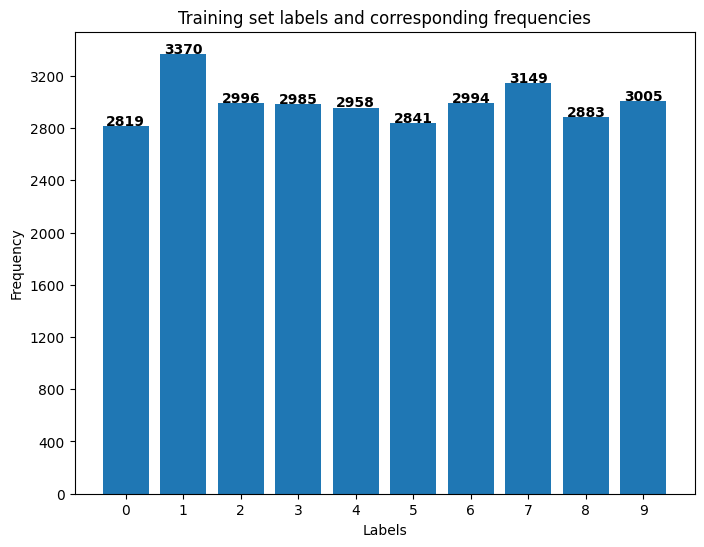

In [11]:
# TRAIN Data
# Import additional libraries
import matplotlib.ticker as ticker

# Function to create bar plots
def create_barplot(data_dict, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Sort the keys
    sorted_keys = sorted(data_dict.keys())
    sorted_values = [data_dict[key] for key in sorted_keys]

    ax.bar(sorted_keys, sorted_values)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    ax.set_xticks(sorted_keys)  # Set x-axis ticks for each bar

    for i, v in enumerate(sorted_values):
        ax.text(sorted_keys[i], v + 5, str(v), 
                horizontalalignment='center', fontweight='bold')

    plt.show()

# Create bar plots for training and testing labels
create_barplot(train_subset_dict, 'Training set labels and corresponding frequencies', 'Labels', 'Frequency')


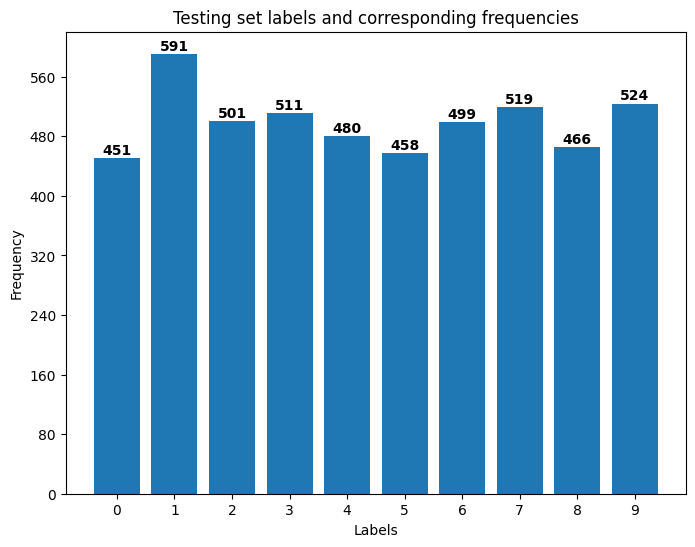

In [12]:
# TEST Data
create_barplot(test_subset_dict, 'Testing set labels and corresponding frequencies', 'Labels', 'Frequency')


### 1.2.3 Visualize the Training Dataset!

Since everything tends to make more sense when one could literally see it, we now visualize the images in the `train_dataset` given a fixed set of indices.

---

**TODO**
* loop through the `train_dataset` using `sample_idxs` (the list of indices provided) using a for-loop
* For each iteration of this for-loop:
  * Plot the current image in grayscale from `train_dataset` indexed by current element in `sample_idxs` using matplotlib in a 2x3 subplot tile
  * Assign the title of each image to be their respective labels using `plt.title`
  * Hide grid lines and axes labels
  





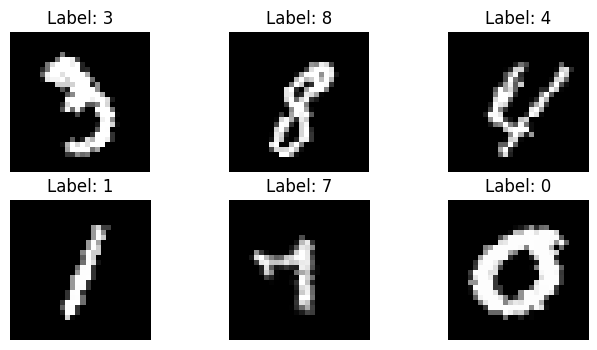

In [13]:
torch.manual_seed(42)
sample_idxs = [10, 300, 700, 2708, 5035, 8000] # DO NOT MODIFY

# # TODO
# loop through the length of tickers and keep track of index

# Create a 2x3 subplot grid to visualize the images
fig, axes = plt.subplots(2, 3, figsize=(8, 4))

# Loop through the sample_idxs and keep track of index
for idx, sample_idx in enumerate(sample_idxs):
    # Get the image and label from train_dataset
    image, label = train_dataset[sample_idx]

    # Calculate the row and column of the current image in the subplot grid
    row, col = idx // 3, idx % 3

    # Plot the image in grayscale
    axes[row, col].imshow(image.squeeze(), cmap='gray')

    # Assign the title of each image to be their respective labels
    axes[row, col].set_title(f"Label: {label}")

    # Hide grid lines and axes labels
    axes[row, col].axis('off')

# Display the plot
plt.show()


# **Part 2:** Classification Models 

We now have the data needed to train a multi-class object classifier. We will start simple with a logistic regression classifier as a baseline for our performance, before we move onto more complex neural networks.

In this case, we are looking at the remaining part in the pipeline which were grayed out before as follows:

<div>
<img src="https://s2.loli.net/2023/03/30/ZCBFQvkXuoJpI8K.png", width = "800"/>
</div>

Diagram Reference: [Link](https://www.kaggle.com/code/uvxy1234/cifar-10-implementation-with-pytorch)

## 2.1 Logical Logistic Regression - Baseline

Let's first try solving this problem with a Logistic Regression classifier.

We will define a logistic regression model in Pytorch and train it on our training set and evaluate the performance on the test set.

Logistic regression can be modelled as a function that can take in any number of inputs and constrain the output to be between 0 and 1. This means we can think of Logistic Regression as a one-layer neural network without hidden layers with Sigmoid as an activation function.

<div>
<img src='https://i.stack.imgur.com/fKvva.png',width='600'/>
</div>

Diagram Reference: [Link](https://stats.stackexchange.com/questions/366707/a-logistic-regression-with-neural-network-mindset-vs-a-shallow-neural-network)

### 2.1.1 Logistic Regression Model Architecture 

We will define our first model in Pytorch. 

Our first model is a logistic regression model with the number of outputs equal to the number of classes in the model. Please implement the constructor for the `LogReg` class (the `__init__` function below) with the definition of the logistic regression model.

In [14]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        #Initialize the neural network layers
        #self.linear = nn.Linear(28 * 28, 10)
        #self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten(start_dim=1)
        self.linear = nn.Linear(28 * 28, 10)
        self.sigmoid = nn.Sigmoid()

        
    def forward(self, x):
        #Implement the operations on input data
        #x = x.view(x.size(0), -1)  # Flattening the input tensor
        #outputs = self.linear(x)
        #outputs = self.sigmoid(outputs)
        x = self.flatten(x)  # Flattening the input tensor
        outputs = self.linear(x)
        outputs = self.sigmoid(outputs)
        
        return outputs

**Let**'s print the model summary

In [15]:
LogReg()

LogReg(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)

### 2.1.2 Training Logistic Regression Model (6 points)

---
We will use `train_loader` built in 1.1.2 to train logistic regression model.

The optimizer is set as Adam.


Note: `acc_LIST_log` and `loss_LIST_log` should contain data of type float not tensor.

In [16]:
%%time
# Sending the data to device (CPU or GPU)
# Step 1: instantiate the logistic regression to variable logreg
logreg = LogReg().to(device)

# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(logreg.parameters(), lr=1e-4) #lr - learning step
epoch = 10

loss_LIST_log = []
acc_LIST_log = []

# Train the Logistic Regression
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)
      
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()

      # Step 2: Feed the network the train data
      outputs = logreg(inputs)
     
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs.data, 1)
     
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
    
      # Step 5: Do a back propagation
      loss.backward()
     
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()

      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()
      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_log
  accuracy = (correct / total) * 100
  acc_LIST_log.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_log
  loss_LIST_log.append(running_loss / len(train_loader))

  
  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 2.1057475617191175, Accuracy = 44.22333333333333
The loss for Epoch 1 is: 1.94792424768273, Accuracy = 58.85
The loss for Epoch 2 is: 1.8953647651652028, Accuracy = 60.36666666666667
The loss for Epoch 3 is: 1.8695221066729093, Accuracy = 61.71333333333333
The loss for Epoch 4 is: 1.8476407194950941, Accuracy = 62.27666666666667
The loss for Epoch 5 is: 1.8366572691687644, Accuracy = 62.849999999999994
The loss for Epoch 6 is: 1.8284962680548238, Accuracy = 63.32666666666667
The loss for Epoch 7 is: 1.8222616862640706, Accuracy = 62.98666666666667
The loss for Epoch 8 is: 1.8174795804501596, Accuracy = 63.05666666666667
The loss for Epoch 9 is: 1.8116164687854142, Accuracy = 63.77
CPU times: user 6min 15s, sys: 2.15 s, total: 6min 17s
Wall time: 6min 24s


### 2.1.3 Plotting Training Accuracy vs Epochs for Logistic Regression

**TODO:**

Plot the training accuracy vs epochs.

Chart Specifications:
1. The accuracy should be in the y-axis and epochs in x-axis.
2. Add chart title.
3. Epoch label should start with 1 (for audience interpretability).
---

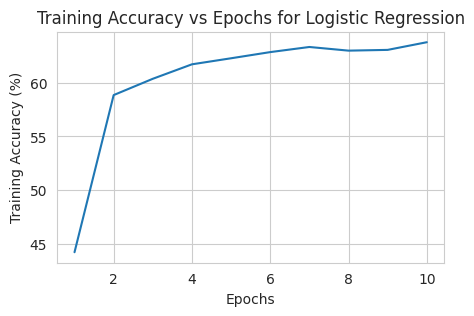

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(5, 3))
sns.set_style("whitegrid")
plt.plot(range(1, len(acc_LIST_log) + 1), acc_LIST_log)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy (%)")
plt.title("Training Accuracy vs Epochs for Logistic Regression")
plt.show()



### 2.1.4 Logistic Regression Model Accuracy (2 points)

Calculate the Test Accuracy for the Logistic Regression Model we trained above.



In [18]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)
        
        
        # Get the output
        outputs = logreg(images)

        # Get the prediction using argmax
        _, predicted = torch.max(outputs.data, 1)
        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum()
# Calculate test accuracy for logistic regression (should multiple by 100)
test_acc_log = (correct / total) * 100

print('Test Accuracy: ' + str(test_acc_log.item()))

Test Accuracy: 63.87999725341797


## 2.2 Feedforward Neural Networks (Total: 25 points)

<div>
<img src='https://s2.loli.net/2022/11/21/dvqstVUzcQPChD1.png', width='400'/>
</div>

Diagram reference: [Link](https://en.wikipedia.org/wiki/Feedforward_neural_network)

Since logistic regression isn't that great at the classification problem above, we need more representation power in our model. We will now define a feedforward neural network.

We create the *FNN* class below to define a feedforward neural network with **only 1 hidden layers with ```out_features``` of 256**. Note that the last layer must have the same number of classes as the output size! 



### 2.2.1 Feedforward Neural Network Model Architecture 

In [19]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize the neural network layers
        self.input_layer = nn.Linear(28 * 28, 256)
        self.hidden_activation = nn.ReLU()
        self.output_layer = nn.Linear(256, 10)


    def forward(self, x):
        #Implement the operations on input data
        x = x.view(x.size(0), -1)  # Flattening the input tensor
        x = self.input_layer(x)
        x = self.hidden_activation(x)
        outputs = self.output_layer(x)

        # END TODO
        return outputs

Let's print the model summary

In [20]:
FNN()

FNN(
  (input_layer): Linear(in_features=784, out_features=256, bias=True)
  (hidden_activation): ReLU()
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
)

### 2.2.2 Training FNN Model (11 points)
---
TODOs
1.   Instantiate the FNN to the variable `fnn` (make sure to send this to the device env)
2.   Set the loss criterion to be `CrossEntropyLoss` (you can look up the documentation [here](https://pytorch.org/docs/stable/nn.html#loss-functions))
3.   Fill in the missing parts in the training loop below.
4.   Save the Training Accuracy for every epoch into `acc_LIST_FNN`
5.   Save the Average Loss for every epoch into `loss_LIST_FNN`
---
The optimizer is set as Adam.


**Note: If the loss went up during the training, there is something wrong with the model, so you should check if the model is implemented correctly**

The following code block should take around 4-5 minutes to complete.

Note: `acc_LIST_FNN` and `loss_LIST_FNN` should contain data of type float not tensor.

In [21]:
%%time
# Sending the data to device (CPU or GPU)

# Step 1: instantiate the FNN model to variable fnn
fnn = FNN().to(device)

# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# END TODO 
optimizer = optim.Adam(fnn.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_FNN = []
loss_LIST_FNN = []

# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)
      
      ## TODO (2 of 2)
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      
      # Step 2: Feed the network the train data
      outputs = fnn(inputs)
      
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs.data, 1)
      
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      
      # Step 5: Do a back propagation
      loss.backward()
      
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()

      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()

      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_FNN
  accuracy = 100 * correct / total
  acc_LIST_FNN.append(accuracy)
  
  # Step 10: Get average loss for each epoch and add to loss_LIST_FNN
  avg_loss = running_loss / len(train_loader)
  loss_LIST_FNN.append(avg_loss)
  

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 1.3328551306907557, Accuracy = 59.00666666666667
The loss for Epoch 1 is: 0.9710359157783899, Accuracy = 69.61666666666666
The loss for Epoch 2 is: 0.8313210658681418, Accuracy = 74.46666666666667
The loss for Epoch 3 is: 0.7435561656824815, Accuracy = 77.11333333333333
The loss for Epoch 4 is: 0.6691143862220016, Accuracy = 79.59
The loss for Epoch 5 is: 0.6109245070008072, Accuracy = 81.43
The loss for Epoch 6 is: 0.5657435048744877, Accuracy = 82.83333333333333
The loss for Epoch 7 is: 0.5285375748616038, Accuracy = 84.16666666666667
The loss for Epoch 8 is: 0.4925922754921639, Accuracy = 85.43
The loss for Epoch 9 is: 0.4605950486621877, Accuracy = 86.21333333333334
CPU times: user 6min 18s, sys: 1.23 s, total: 6min 20s
Wall time: 6min 21s


### 2.2.3 Plotting Training Accuracy vs Epochs FNN 
---
**TODO:**

Plot the training accuracy vs epochs.

Chart Specifications:
1. The accuracy should be in the y-axis and epochs in x-axis.
2. Add chart title.
3. Epoch label should start with 1 (for audience interpretability).
---

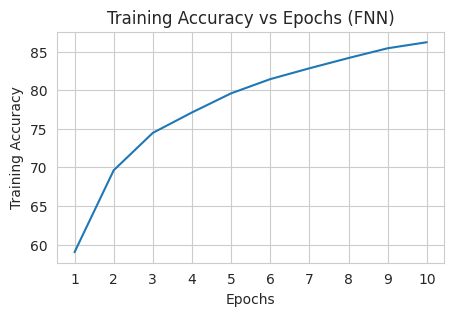

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(acc_LIST_FNN) + 1), acc_LIST_FNN)
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs Epochs (FNN)')
plt.xticks(range(1, len(acc_LIST_FNN) + 1))
plt.show()


### 2.2.4 FNN Model Accuracy

Calculate the Test Accuracy for the FNN Model we trained above (the technique for doing this is the same as computing the test accuracy for the logistic regression classifier above). 

In [23]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

       
        # Get the output
        outputs = fnn(images)
        
        # Get the prediction using argmax
        _, predicted = torch.max(outputs.data, 1)
        
        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum()

# Calculate test accuracy for FNN (should multiple by 100)
test_acc_FNN = (correct / total) * 100

print('Test Accuracy: ' + str(test_acc_FNN.item()))

Test Accuracy: 86.55999755859375


##2.3 "Convoluted" Convolutional Neural Networks 
So, what are CNNs?

Convolutional Neural Networks are very similar to Feedforward Neural Networks from the previous section: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other.

So what changes? ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.



<div>
<img src='https://s2.loli.net/2022/11/21/L6pUz2chXWRGn31.png', width='800'>
</div>

Diagram Reference: [Link](https://www.analyticsvidhya.com/blog/2020/10/what-is-the-convolutional-neural-network-architecture/)

We will define the architecture for the CNN we will be using. The components of a CNNs are as follows: 

*   Convolutional Layers
*   Pooling Layers
*   Linear Layers
*   Activation Functions

Define a CNN model with Pytorch that contains one or more blocks, where **each block** consists of a **convolutional layer** followed by an **activation function** and a **max pool**. (For this assignment, we discourage adding three or more layers.)

Then, **flatten** the output from the convolutional layers, and pass it through one or more fully connected or 'dense' layers and activation functions after all but the last layer. Note that the output shape from the last layer must be the same as the number of classes.

### 2.3.0 Calculating Output Dimensions of Convolution and Pooling Layers 

Before we start building the architecture, it's important to understand the dimensions of the feature maps produced in each of the convolution and pooling layers. We want to keep track of this information as once we get to the fully-connected layers, we need to specify the number of input parameters. 

Let's first build a function that will help us calculate the dimensions based on the input parameters.


Since we are working with squared image, we will build just one function that can be used to calculate both the H (height) and W (width) of the feature map.

Below is the function used to calculate the output dimension of the feature map: 

<div>
<img src='https://s2.loli.net/2023/03/30/lKpjPLVHcuRC8n2.png',width='300'/>
</div>

Diagram Reference: [Link](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

---
**TODO:**

Build the **feature_map_dim** function, which takes in the following four parameters and return the dimension of the output feature map.

- **input_dim**: height/width of the input image

- **kernel_size**: size of the convolving kernel (aka. filter)

- **padding**: padding added to all four sides of the input in order to preserve the edges/borders

- **stride**: Stride of the convolution, or how many shifts per kernel
  
ROUND DOWN if the result if a fraction.

---

Notice there is another parameter, "dilation", which is the spacing between kernel elements. Simply set it to 1.
 

In [24]:
import math

def feature_map_dim(input_dim, padding, kernel_size, stride):
  
  output_dim = math.floor((input_dim - kernel_size + 2 * padding) / stride) + 1
  return output_dim

  

### 2.3.1 Convolutional Neural Network Model Architecture (12 points)

---
**TODOs:**

`def __init__(self)`:: 
1.  Initialize 1 - 3 `convolutional blocks` (consists of a convolution layer, an activation function, and a Pooling layer) 

2. `Flatten` the output of the convolution to a tensor

3. Initialize 1-3 `fully-connected layers`

`def forward(self, x)`: 
4. Build the `forward` function/path with the layers initialized in `__init__` function. 





In [25]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Step 1: Initialize 1 - 3 convolution blocks (consists of a convolution layer, an activation function, a MaxPooling layer)
        
        ## you are encouraged to use the following comments to keep track of the output dimensions
        # input dim = __ channels, with image size __ x __
        # output dim = __ channels, with image size __ x __
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolution Block 1

        # Convolution Block 2 ... Feel free to add 1 - 2 more convolution blocks
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Step 2: Flatten the 2D image into a 1D tensor  
        #input_dim: 32 * 7 * 7
        self.flatten = nn.Flatten(start_dim=1)

        # Step 3: Initialize 1-3 fully-connected layers
        self.fc1 = nn.Linear(in_features=1568, out_features=128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=128, out_features=10)
    

    
    def forward(self, x):

        #print(x.size())

        # Step 1. Pass the images (x) through convolution block 1 and (block 2, 3 if you have built them)
        x = self.conv_block1(x)

        #print(x.size())
        x = self.conv_block2(x)
        
        #print(x.size())
        # Step 2. Flatten the image
        x = self.flatten(x)
       
        
        # Step 3. Pass the output through the fully-connected layers (remember to include activation function(s))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        outputs = nn.functional.softmax(x, dim=1)

        
        return outputs  #changed from outputs

Let's print out the model summary

In [26]:
CNN()

CNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### 2.3.2 Training CNN Model 
---
**TODOs**
1.   Instantiate the CNN to the variable `cnn` (make sure to send this to the device env)
2.   Set the criterion as a CrossEntropyLoss 
3.   Fill in the missing parts in the training loop.
4.   Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called `accuracy`.
5.   Save the Training Accuracy for every epoch into `acc_LIST_CNN`
6.   Save the Average Loss for every epoch into `loss_LIST_CNN`

Optimizer: The optimizer is set as "Adam".
Epoch: The epoch is set to "10".

---



In [27]:
%%time
# Sending the data to device (CPU or GPU)
# Step 1: instantiate the CNN model to variable cnn
cnn = CNN().to(device)

# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_CNN = []
loss_LIST_CNN = []

# Train the CNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)

      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()

      # Step 2: Feed the network the train data
      outputs = cnn(inputs)

      # Step 3: Get the prediction using argmax
      predicted = outputs.argmax(dim=1)


      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)

      # Step 5: Do a back propagation
      loss.backward()

      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()

      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()

      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_CNN
  accuracy = 100 * correct / total
  acc_LIST_CNN.append(accuracy)

  # Step 10: Get average loss for each epoch and add to loss_LIST_CNN
  loss_LIST_CNN.append(running_loss/len(train_loader))

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 2.048223296462346, Accuracy = 45.50666666666667
The loss for Epoch 1 is: 1.8527930153966712, Accuracy = 62.77333333333333
The loss for Epoch 2 is: 1.7244913374691375, Accuracy = 76.42333333333333
The loss for Epoch 3 is: 1.6643718036253061, Accuracy = 81.67
The loss for Epoch 4 is: 1.6357059931195874, Accuracy = 84.19
The loss for Epoch 5 is: 1.6103127450068622, Accuracy = 86.46333333333334
The loss for Epoch 6 is: 1.59788379232004, Accuracy = 87.59333333333333
The loss for Epoch 7 is: 1.586091742332556, Accuracy = 88.69333333333333
The loss for Epoch 8 is: 1.5787430831364222, Accuracy = 89.32
The loss for Epoch 9 is: 1.570273938463695, Accuracy = 90.08
CPU times: user 6min 23s, sys: 1.53 s, total: 6min 25s
Wall time: 6min 29s


### 2.3.3 Plotting Training Accuracy vs Epochs CNN 
---
**TODO:**

Plot the training accuracy vs epochs.

Chart Specifications:
1. The accuracy should be in the y-axis and epochs in x-axis.
2. Add chart title.
3. Epoch label should start with 1 (for audience interpretability).
---

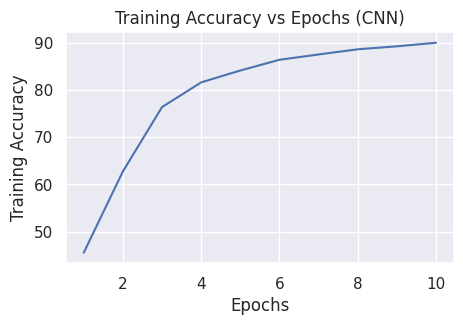

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 3))

# Plot the training accuracy vs epochs
ax.plot(range(1, len(acc_LIST_CNN) + 1), acc_LIST_CNN)

# Set x and y axis labels
ax.set_xlabel('Epochs')
ax.set_ylabel('Training Accuracy')

# Set the title
ax.set_title('Training Accuracy vs Epochs (CNN)')

# Display the plot
plt.show()



### 2.3.4 CNN Model Test Accuracy 

---
**TODO:**
Calculate the Test Accuracy for the CNN Model trained above. Save it to the variable named `test_acc_CNN`. The technique for doing this is the same as computing the test accuracy for the logistic regression and FNN classifiers above.

---

In [29]:
# TODO
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)
        # Get the output
        outputs = cnn(images)

        # Get the prediction using argmax
        _, predicted = torch.max(outputs.data, 1)

        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum()

# Calculate test accuracy for CNN (should multiple by 100)
test_acc_CNN = 100 * correct / total

print(f'Test Accuracy: ' + str(test_acc_CNN.item()))

Test Accuracy: 91.89999389648438


## 2.4. Final Accuracies
---




In [30]:
# Simply run this cell, please do not modify
print(f'Test Accuracy for Logistic Regression: ' + str(test_acc_log.item()))
print(f'Test Accuracy for FNN: ' + str(test_acc_FNN.item()))
print(f'Test Accuracy for CNN: ' + str(test_acc_CNN.item()))

Test Accuracy for Logistic Regression: 63.87999725341797
Test Accuracy for FNN: 86.55999755859375
Test Accuracy for CNN: 91.89999389648438


## 2.5 Confusion Matrix 

Upto now we have only used accuracy as a measure of performance. Although accuracy is simple and widely used measure, there are drawbacks to using accuracy.

Assume that we are trying to train a model to detect a rare disease from CT images of patients. For simplicity, assume that this rare disease has an incidence rate of 1%.

In this situation, if we train a degenerative model which always predicts that the patient does not have the disease, the accuracy is very high, namely 99%! Obviously in this case, accuracy is not a good measure of performance of the model.

This example serves to motivate confusion matrices and related metrics.

A confusion matrix is defined to be $C \times C$ 2D matrix, where $C$ is number of distinct labels in the dataset. In this matrix, the rows represent the actual labels and the columns represent the predicted labels. 

The $(i, j)$-th entry of the confusion matrix contains the no. of data points where the actual label is $i$ but the model predicted $j$. 

<div>
<img src='https://s2.loli.net/2023/04/02/7T1e5dtYGihvrRN.png', width='600'>
</div>

The provided image is an example of a confusion matrix for binary classification (C = 2), but you can easily imagine this scaling up to C > 2.

From this confusion matrix we can get all sorts of useful metrics such as False Positive Rate (FPR), False Negative Rate (FNR), Recall, Precision, etc... If you are interested in learning more about confusion matrix and related metrics [this wikipedia page](https://en.wikipedia.org/wiki/Confusion_matrix#cite_note-11) is a good place to look at. 







### 2.5.1 Create a confusion matrix 

---

**TODO:**
1. For the test dataset using the CNN model you have trained above, create a confusion matrix. 
2. Save the confusion matrix as a pandas dataframe called `confusion_matrix_df`.

---


In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix


def cm_generator(test_loader):

  # The goal is to obtain two lists of prediction and actual labels.
  # Then, using these two lists, create a confusion matrix dataframe
  y_true = []
  y_pred = []

  with torch.no_grad():
        for images, labels in test_loader:
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

  # Create the confusion matrix
  cm = confusion_matrix(y_true, y_pred)
    
  # Create a pandas dataframe with row and column labels
  confusion_matrix_df = pd.DataFrame(cm, index=[str(i) for i in range(10)], columns=[str(i) for i in range(10)])

  return confusion_matrix_df

# Generate confusion matrix dataframe
confusion_matrix_df = cm_generator(test_loader)
print(confusion_matrix_df)

     0    1    2    3    4    5    6    7    8    9
0  419    0    5    5    1    3    8    1    4    5
1    1  565    5    3    8    0    4    5    0    0
2    7    3  434    1   14    1    2   24   13    2
3    4    0    4  476    2    8    1    2    9    5
4    0    2    6    1  456    1    2    3    0    9
5    6    1    0    6    6  410   20    1    6    2
6    3    2    3    2   10    7  468    0    3    1
7    2    5   10    5    4    1    0  475    2   15
8    3    4    7    4    2    4   10    4  422    6
9    1    2    2    5   15    7    2   10    4  476


### 2.5.2 Visualizing Confusion Matrix

---
**TODOs:**


Chart Specifications:
1. Each cell is labled/annotated with associated values. Take a look at the parameter "annot". 
2. Make sure all annotated values are in integers, and not shown in scientific notations. Use the parameter `fmt = "g"`.
3. Add chart title, and axis name label ("Actual" and "Predicted". Check out which axis is associated with either label.
4. Set map color to Green/Blue.
5. To avoid "File Too Large" for submission, please set figure size to (8,4).
---
Resource: [Seaborn Heatmap documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html )

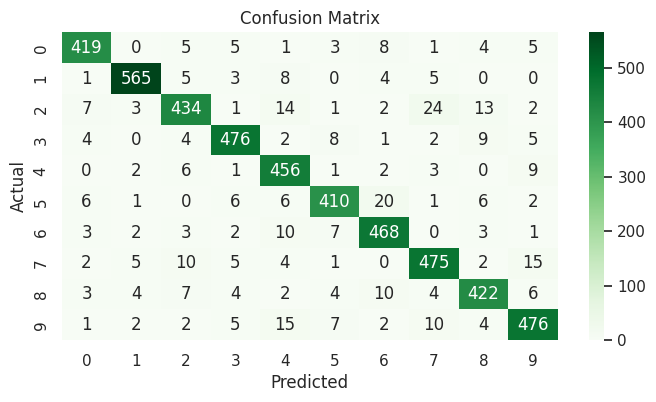

In [32]:


import seaborn as sns

def visualize_confusion_matrix(confusion_matrix_df):
    plt.figure(figsize=(8, 4))
    sns.heatmap(confusion_matrix_df, annot=True, fmt="g", cmap="Greens")
    
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.show()

visualize_confusion_matrix(confusion_matrix_df)


